# Stock Proce Predictor
### Udacity Data Scientist Nanodegree - Capstone Project

This notebook covers
* the integration of Yahoo stock price data,
* the exploration of stock price data,
* data preprocessing, and
* the comparison of different predictor models.

The code will then be utilized to build a flask app for predicting stock prices.

The predictor's performance is measured against the actual future price with a variance of 5% (Udacity requirement) plus further indicators.

**Disclaimer:** Do not use this project for investment decisions. This project is for education purposes only.

## Table of Contents

01   [Obtaining & Exploring the Data](#Exploration)<br>
02   [Data Preprocessing](#Preprocessing)<br>
03   [Model: Recurrent Neural Network](#RNN)<br>
04   [Model: Multiple Linear Regression](#MLR)<br>
05   [Model: Random Forest Regression](#RFR)<br>
06   [Model: Polynomial Regression](#PR)<br>
07   [Machine-Learning Pipeline + LASSO, Ridge, ElasticNet Models](#Pipeline)<br>

In [118]:
# Import libraries
import os

import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline #, FeatureUnion
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
#from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
#from sklearn.feature_selection import SelectKBest, mutual_info_regression

import statsmodels.regression.linear_model as sm

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### <a class="anchor" id="Exploration">Part 1: Obtaining & Exploring the Data</a>

In [ ]:
# Import Yahoo Finance CSV Data on Microsoft stock
data = pd.read_csv('data/MSFT.csv')

In [ ]:
data.info()

In [ ]:
data.hist()
plt.tight_layout()

In [ ]:
scatter_matrix(data, figsize=(10, 10))

In [ ]:
data.head(-10)

In [ ]:
data['Adj Close']

In [ ]:
# Plot Close and Adjusted Close for comparison
plt.plot(data['Close'], color = 'blue', label = 'Close')
plt.plot(data['Adj Close'], color = 'red', label = 'Adj Close')
plt.title('Close vs. Adjusted Close')
plt.xlabel('Time')
plt.ylabel('MSFT Price')
plt.legend()
plt.show()

In [ ]:
# Plot difference between Close and Adjusted Close
close_diffs = data.copy()
close_diffs['Close Diffs'] = close_diffs['Close'] - close_diffs['Adj Close']

plt.plot(close_diffs['Close Diffs'], color = 'red', label = 'Close Diffs')
plt.title('Difference between Close and Adjusted Close')
plt.xlabel('Time')
plt.ylabel('MSFT Price')
plt.legend()
plt.show()

In [ ]:
# Take a closer look at Close Diffs
plt.plot(close_diffs['Close Diffs'][-150:], color = 'red', label = 'Close Diffs')
plt.title('Difference between Close and Adjusted Close / last 150 days')
plt.xlabel('Time')
plt.ylabel('MSFT Price')
plt.legend()
plt.show()

**Comment**

Yahoo Finance applies the following adjustments to the numbers:
1. Close price adjusted for splits.
2. Adjusted close price adjusted for both dividends and splits.

The effect of dividends can clearly be seen in the above chart: Every three months Microsoft's (MSFT) shareholders earn a dividend. The close price is then adjusted by this cash outflow so that the adjusted close price better resembles the value of the company (and its stocks respectively) after the dividend event. Since cash (in form of dividend payments) leaves the company but is not reinvested, the value of the company and its shares respectively dilute.

Udacity's requirement for this capstone project is to predict the **adjusted close price**. Hence, this is the value the prediction models will concentrate on.

### <a class="anchor" id="Preprocessing">Part 2: Data Preprocessing</a>

In [2]:
def import_data(data = 'data/MSFT.csv'):
    '''
    Function to import and preprocess stock price data from Yahoo Finance for further usage.
    Input: Path to CSV file provided by Yahoo Finance
    Output: Preprocessed DataFrame
    '''
    df = pd.read_csv(data)
    df = preprocessing_data(df)
    return df


def preprocessing_data(df):
    '''
    Function to preprocess data: formatting, cleaning, forward-fill and backward-fill for nan values
    Input: df with stock price data
    Output: Preprocessed DataFrame
    '''
    # Format Date column
    df['Date'] = df['Date'].astype('datetime64[ns]')
    
    # Check if there are nan values
    for col in df.columns:
        if df[col].isnull().sum() >> 0:
            df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
        else:
            continue
         
    return df

In [ ]:
# Test functions
# Add nan value in one column
df_1nan = import_data()
df_1nan['Close'][4] = np.nan
df_1nan.head()

In [ ]:
# Test preprocessing function for one nan
df_1nan = preprocessing_data(df_1nan)
assert df_1nan['Close'][4] == df_1nan['Close'][3], 'forward-fill did not work'

In [ ]:
# Test preprocessing function for more nan values
df_nans = import_data()
df_nans['Close'][3] = np.nan

# Create DataFrame with one row of nan values
nan_list = [np.nan for _ in range(len(df_nans.columns))]
nanrow_df = pd.DataFrame(nan_list)#, columns = df_nans.columns.to_list())
nanrow_df = nanrow_df.T
nanrow_df.columns = df_nans.columns.to_list()

# Create a DataFrame with nan values at the beginning (test backward-fill), in the middle and the end (test forward-fill)
nans_df = nanrow_df.append(df_nans)
nans_df = nans_df.append(nanrow_df)
nans_df

In [ ]:
# Apply preprocessing function to DataFrame with NaN values
test_nan_df = preprocessing_data(nans_df)
test_nan_df

--> both data import and preprocessing functions work properly.

In [3]:
# Function to create DataFrame from different stock data
def batch_import(folder_path = 'data'):
    '''
    Function to import and preprocess stock price data of several stocks from Yahoo Finance for further usage.
    Input: Path to Folder, which contains multiple CSV files provided by Yahoo Finance
    Output: Preprocessed DataFrame
    '''
    # Create list with file names of .csv files
    files = []
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            files.append(file)
    
    # Create first DataFrame
    df = import_data(os.path.join(folder_path, files[0]))
    ticker = files[0][:-4]
    df['Ticker'] = ticker
    
    # Find youngest first date of all stocks (we want to start the time series of each stock from the same date)
    startdate = df['Date'].min()
    for file in files[1:]:
        tmp_filename = os.path.join(folder_path, file)
        tmp_df = import_data(tmp_filename)
        tmp_date = tmp_df['Date'].min()
        if tmp_date > startdate:
            startdate = tmp_date
    
    # Filter df for equal timerange
    df = df[df['Date'] > startdate]
    
    # Merge other stock datasets
    for file in files[1:]:
        ticker = file[:-4]
        tmp_filename = os.path.join(folder_path, file)
        tmp_df = import_data(tmp_filename)
        tmp_df = tmp_df[tmp_df['Date'] > startdate]
        tmp_df['Ticker'] = ticker
        df = pd.concat([df, tmp_df])
         
    return df

In [ ]:
# Check batch_import function    
df = batch_import()
df.head(-5)

In [ ]:
# There are nine files in the data folder
# with FB (facebook) the youngest stock with a starting date of 2012-05-21
tickers_list = df['Ticker'].unique().tolist()
tickers_len = len(tickers_list)
first_date = df['Date'].min()
first_date_occurence = df[df['Date'] == first_date].shape[0]

print('The DataFrame covers {} different stocks/tickers.'.format(tickers_len))
print('The starting date for all tickers is: {}'.format(first_date))
print('It occurs {} times, which equals the number of the different tickers.'.format(first_date_occurence))
print('List of tickers:')
print(tickers_list)

--> The batch_import function to import several tickers from a data folder works as intended.

### <a class="anchor" id="RNN">Part 3: Model: Recurrent Neural Network</a>
The RNN will be trained on S&P 500 data of the past 20 years to predict the Adj. Close for the following day.

In [ ]:
# Import SPY dataset
dataset = import_data(data = 'data/SPY.csv')
# Obtain a slice of the past 20 years
startdate = dataset['Date'].max() - pd.DateOffset(years=20)
dataset = dataset[dataset['Date'] > startdate]

In [ ]:
dataset.head(-5)

In [ ]:
# Split dataset into training and test sets
df_adjClose = dataset.iloc[:, 5:6].values    # Adj. Close column
adjClose_train, adjClose_test = train_test_split(df_adjClose, test_size = 0.2, shuffle = False)    # no shuffle for time-series

In [ ]:
# Feature Scaling / Data Normalization
scaler = MinMaxScaler(feature_range = (0, 1))
adjClose_train_scaled = scaler.fit_transform(adjClose_train)

In [ ]:
# Create data structure with 32 timesteps and 1 output
X_train = []
y_train = []
for i in range(32, len(adjClose_train)):
    X_train.append(adjClose_train_scaled[i-32:i, 0])
    y_train.append(adjClose_train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping --> Define expected dimensionality for RNN
# X_train.shape[0] = Number of rows
# X_train.shape[1] = Number of columns
# 1 = Number of features (in this case only 'Adj Close')
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
# Initialize Recurrent Neural Network (RNN)
regressor = Sequential()

# Create first long short-term memory (LSTM) layer
# units = neurons in LSTM layer
# return_sequences = True <-- as more LSTM layers will follow
# dropout <-- to counteract overfitting
regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.19))

# Add second LSTM layer and dropout regularization
regressor.add(LSTM(units = 64, return_sequences = True))
regressor.add(Dropout(0.19))

# Add third LSTM layer and dropout regularization
regressor.add(LSTM(units = 64, return_sequences = True))
regressor.add(Dropout(0.19))

# Add fourth LSTM layer and dropout regularization
regressor.add(LSTM(units = 64))
regressor.add(Dropout(0.19))

# Add output layer
regressor.add(Dense(units = 1, activation = 'linear'))

# Compile RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fit RNN to training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

In [ ]:
# Make preditction for Adj. Close

# Normalize training and test data (again).
# Normalization of the test data has to be done in a separate step so that it does not influence the normalization of the training data, which would be a look into the future.

inputs = df_adjClose[len(df_adjClose) - len(adjClose_test) - 32:]
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
X_test = []
for i in range(32, (32+len(adjClose_test))):
    X_test.append(inputs[i-32:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


predicted_price = regressor.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)

real_price = df_adjClose[len(df_adjClose) - len(adjClose_test):]

In [ ]:
# Visualize the results
plt.plot(real_price, color = 'blue', label = 'Real Adj. Close')
plt.plot(predicted_price, color = 'red', label = 'Predicted Adj. Close')
plt.title('Adj. Close Prediction')
plt.xlabel('Time')
plt.ylabel('Adj. Close')
plt.legend()
plt.show()

### Conclusion:
Tweaking and optimizing the RNN is a project for itself. Although it might result in a very good prediction model, I want something light and sparse with regard to computational ressources.
Hence I will focus on other models.

### <a class="anchor" id="MLR">Part 4: Model: Multiple Linear Regression</a>
A multiple linear regression model uses several features (independent variables) to predict the dependent variable y. As inputs we will use
* the full candle information (Open, High, Low, Close, Adj. Close Volume) of the previous day
* working day (Monday to Friday; these categorial features will be engineered below)

In [ ]:
# Import dataset
dataset = import_data(data = 'data/MSFT.csv')

In [ ]:
# Create column with weekdays from Date column
# Change column format to datetime format
dataset['Date'] = dataset['Date'].astype('datetime64[ns]')
dataset['Weekday'] = dataset['Date'].dt.day_name()

In [ ]:
# Create dummy variable columns for weekdays
dataset = pd.concat([dataset, pd.get_dummies(dataset['Weekday'], drop_first = True)], axis = 1)
dataset.head(-5)

In [ ]:
# Define X and y
X = dataset.drop(['Date', 'Weekday'], axis = 1).values
y = dataset.iloc[:, 5:6].values    # Adj. Close column

In [ ]:
# Perform assignment of previous day to Adj Close
# --> Delete first row of y
y = np.delete(y, 0, 0)
# --> Delete last row of X
X = np.delete(X, -1, 0)

In [ ]:
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

In [ ]:
# Data Normalization
scaler_X = MinMaxScaler(feature_range = (0, 1))
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = MinMaxScaler(feature_range = (0, 1))
y_train = scaler_y.fit_transform(y_train.reshape(-1,1))

In [ ]:
# Fit Multiple Linear Regression Model to training set
mlr_regressor = LinearRegression()
mlr_regressor.fit(X_train, y_train)

# Predict the Test set results
y_pred = mlr_regressor.predict(X_test)

In [ ]:
# Compare real adj. close with predicted value
# Inverse normalization of y_pred to obtain interpretable values
predicted_price = scaler_y.inverse_transform(y_pred)

In [ ]:
# Visualize the results
plt.plot(y_test, color = 'blue', label = 'Real Adj. Close')
plt.plot(predicted_price, color = 'red', label = 'Predicted Adj. Close')
plt.title('Adj. Close Prediction')
plt.xlabel('Time')
plt.ylabel('Adj. Close')
plt.legend()
plt.show()

In [4]:
# Build optimal model with backwards elimination
# Fuction to automatically remove columns where P-value is below significance level of 5%
# and adjusted R² is improved
def backward_elimination_r2(x, X_cols_mod, significance = 0.05):
    '''
    Remove the independent variables where P-values in the multiple linear regression model 
    are below a certain significance level (standard value = 5%), but ensure adjusted R² is improved
    imput:  x =  "modified X" = DataFrame with independent variables and a new column with ones for b0 (y = b0 + b1*x1 + b2*x2 + ... + bn*xn)
            X_cols_mod = list with column names of the x DataFrame
            significance = float with significance level for P-values
    output: x = modified DataFrame only containing independent variables/columns with P-values > significance
    '''
    num_vars = len(x[0])
    temp = np.zeros((x.shape)).astype(int)
    for i in range(0, num_vars):
        regressor_OLS = sm.OLS(endog = y, exog = x).fit()
        max_var = max(regressor_OLS.pvalues).astype(float)
        adjR_before = regressor_OLS.rsquared_adj.astype(float)
        if max_var > significance:
            for j in range(0, num_vars - i):
                if (regressor_OLS.pvalues[j].astype(float) == max_var):
                    temp[:,j] = x[:, j]
                    x = np.delete(x, j, axis = 1)
                    tmp_col = X_cols_mod.pop(j)
                    tmp_regressor = sm.OLS(endog = y, exog = x).fit()
                    adjR_after = tmp_regressor.rsquared_adj.astype(float)
                    if (adjR_before >= adjR_after):
                        x_rollback = np.hstack((x, temp[:,[0,j]]))
                        x_rollback = np.delete(x_rollback, j, 1)
                        X_cols_rollback = X_cols_mod.append(tmp_col)
                        #x = np.hstack((x, temp[:,[0,j]]))
                        #x = np.delete(x, j, 1)
                        #X_cols_mod = X_cols_mod.append(tmp_col)
                        print (regressor_OLS.summary())
                        return x_rollback
                    else:
                        continue
    print(regressor_OLS.summary())
    return x

In [ ]:
# Modify X for backward_elimination_r2 function
# for statsmodel to understand the multiple linear regression equation a new column with b0 equals one is required (y = b0 + b1*x1 + b2*x2 + ... + bn*xn)
X_mod = np.append(arr = np.ones((len(X), 1)).astype(int), values = X, axis = 1)   # Add X to the newly created array of 1s

In [ ]:
# Create X_cols_mod for backward_elimination_r2 function
# list with column names of the x DataFrame
X_cols_mod = dataset.columns.tolist()
X_cols_mod.remove('Date')
X_cols_mod.remove('Weekday')
X_cols_mod.insert(0,'b0')

In [ ]:
X_modeled = backward_elimination_r2(X_mod, X_cols_mod)

In [ ]:
print(X_cols_mod)

--> The columns of weekdays and volume do not contribute enough to the optimized model  
--> Repeat predictions with optimized X: X_modeled

In [ ]:
# Repeat predictions with optimized X: X_modeled
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_modeled, y, test_size = 0.2, shuffle = False)

# Data Normalization
scaler_X = MinMaxScaler(feature_range = (0, 1))
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = MinMaxScaler(feature_range = (0, 1))
y_train = scaler_y.fit_transform(y_train.reshape(-1,1))

# Fit Multiple Linear Regression Model to training set
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predict the Test set results
y_pred = regressor.predict(X_test)

# Compare real adj. close with predicted value
# Inverse normalization of y_pred to obtain interpretable values
predicted_price = scaler_y.inverse_transform(y_pred)

# Visualize the results
plt.plot(y_test, color = 'blue', label = 'Real Adj. Close')
plt.plot(predicted_price, color = 'red', label = 'Predicted Adj. Close')
plt.title('Adj. Close Prediction')
plt.xlabel('Time')
plt.ylabel('Adj. Close')
plt.legend()
plt.show()

### Conclusion:
The multiple linear regression seems to work well from the beginning and even better after backwards elimination of features (unfortunately the features I engineered additionally...). 
I will include this model in the final representation of the predictor and use the functions for the following regression models.

### <a class="anchor" id="RFR">Part 5: Model: Random Forest Regression</a>
Similar to the multiple linear regression model, we will use the following features for the random forest regression model:
* the full candle information (Open, High, Low, Close, Adj. Close Volume) of the previous day
* working day (Monday to Friday; these categorial features will be engineered below)

That means we can use X_train, X_test, y_train and y_test from the regression model. We only need to build a new regressor to predict new y_pred values.

In [ ]:
# Start with dataset from scratch (for Random Forest Regression I do not recommend starting with too many features)
# Import dataset
dataset = import_data(data = 'data/MSFT.csv')

In [ ]:
# Define X and y
X = dataset.drop(['Date'], axis = 1).values
y = dataset.iloc[:, 5:6].values    # Adj. Close column

In [ ]:
# Perform assignment of previous day to Adj Close
# --> Delete first row of y
y = np.delete(y, 0, 0)
# --> Delete last row of X
X = np.delete(X, -1, 0)

In [ ]:
# Split dataset into training and test sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size = 0.2, shuffle = False)

In [ ]:
# Data Normalization
scaler_X_rf = MinMaxScaler(feature_range = (0, 1))
X_train_rf = scaler_X_rf.fit_transform(X_train_rf)
X_test_rf = scaler_X_rf.transform(X_test_rf)

scaler_y_rf = MinMaxScaler(feature_range = (0, 1))
y_train_rf = scaler_y_rf.fit_transform(y_train_rf.reshape(-1,1))

In [ ]:
y_train_rf

In [ ]:
# Create Random Forest Regressor and fit it to dataset
rf_regressor = RandomForestRegressor(n_estimators = 10, bootstrap = False, min_samples_leaf = 25)
y_train_rf = y_train_rf.ravel()
#rf_regressor.fit(X_train, y_train_rf)

In [ ]:
# Show model hyperparameters
rf_regressor.get_params()

In [ ]:
# Define hyperparameters to optimize with GridSearch cross validation
rf_params = {'n_estimators':[1, 16, 32, 64, 100, 200], 'max_features':['auto','sqrt',0.25, 0.33]}

In [ ]:
# Optimize model with GridSearchCV
rf_cv = GridSearchCV(rf_regressor, param_grid = rf_params, cv=10,n_jobs=-1)
rf_cv.fit(X_train_rf, y_train_rf)

In [ ]:
# Predict the Test set results
y_pred_rf = rf_cv.predict(X_test_rf)

In [ ]:
y_pred_rf = y_pred_rf.reshape((len(y_pred_rf), 1))

In [ ]:
# Compare real adj. close with predicted value
# Inverse normalization of y_pred to obtain interpretable values

predicted_price_rf = scaler_y_rf.inverse_transform(y_pred_rf)

In [ ]:
y_pred_rf

In [ ]:
predicted_price_rf

In [ ]:
# Visualize the results
plt.plot(y_test, color = 'blue', label = 'Real Adj. Close')
plt.plot(predicted_price_rf, color = 'red', label = 'Predicted Adj. Close')
plt.title('Adj. Close Prediction')
plt.xlabel('Time')
plt.ylabel('Adj. Close')
plt.legend()
plt.show()

In [ ]:
rf_cv.best_score_

### Conclusion:
After tweaking and testing the random forest model I am not getting valuable predictions. Either the model or my implementation are not suited for this prediction task.
Hence I will focus on the other models.

### <a class="anchor" id="PR">Part 6: Model: Polynomial Regression</a>
Similar to the multiple linear regression model, we will use the following features for the polynomial regression model:
* the full candle information (Open, High, Low, Close, Adj. Close Volume) of the previous day
* working day (Monday to Friday; these categorial features will be engineered below)

That means we can use X_train, X_test, y_train and y_test from the regression model. The polynomial regressor sits on top of the multiple linear regressor but adds polynomial features.

In [ ]:
# Fit Polynomial Regression to the data
poly_regressor = PolynomialFeatures(degree = 2)
X_train_poly = poly_regressor.fit_transform(X_train)
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_train_poly, y_train)

In [ ]:
# Show model hyperparameters
poly_regressor.get_params()

In [ ]:
# Show model hyperparameters
lin_reg_2.get_params()

In [ ]:
# Predicting a new result with Polynomial Regression
y_pred_poly = lin_reg_2.predict(poly_regressor.fit_transform(X_test))

In [ ]:
# Inverse normalization of y_pred to obtain interpretable values
predicted_price_poly = scaler_y.inverse_transform(y_pred_poly)

In [ ]:
# Visualize the results
plt.plot(y_test, color = 'blue', label = 'Real Adj. Close')
plt.plot(predicted_price_poly, color = 'red', label = 'Predicted Adj. Close')
plt.title('Adj. Close Prediction')
plt.xlabel('Time')
plt.ylabel('Adj. Close')
plt.legend()
plt.show()

### Conclusion:
The polynomial regression with a degree of 2 looks fine and will be included in the final representation of predictions.

### <a class="anchor" id="Optimize">Part 7: Build and Optimize Further Models (LASSO, Ridge, ElasticNet, SVR)</a>
In this part we will build a machine learning pipeline to optimize our regression models with cross-validation, namely
* Multiple Linear Regression
* Polynomial
* LASSO
* Ridge
* ElasticNet
* Support Vector Regression (SVR) as a non-linear model

The models will be trained four times for the prediction steps: 1 day, 7, 14, 28 days 

Similar to the multiple linear regression model, we will use the following features:
* the full candle information (Open, High, Low, Close, Adj. Close Volume) of the previous day
* working day (Monday to Friday; these categorial features will be engineered below)

In [5]:
def import_engineer_data(batch_import = False, folder_path = 'data/SPY.csv', weekday_feature = False, window = 1):
    '''
    Function to import, preprocess and feature engineer stock price data of several stocks from Yahoo Finance for further usage.
    Inputs: 
        batch_import       BOOL; True: Import all .csv files in given folder; False: Import single .csv file
        folder_path        STR; Path to Folder, which contains multiple CSV files provided by Yahoo Finance
                                If batch_import = False: folder_path must point to specific file, e.g. 'data/MSFT.csv'
        weekday_feature    BOOL; if true dummy variables for weekdays monday-friday are engineered
        window             INT; how many working days shall y be shifted from X (e. g. predict the price of tomorrow (1) or in one week (5))
    Outputs:
        X                  numpy array; independent variables
        y                  numpy array; dependent variable
        X_cols             list; showing column names, representing the names of the independent variables
    '''
    if batch_import:
        df = batch_import(folder_path)
        df = df.drop(['Ticker'], axis = 1)
    else:
        df = import_data(folder_path)
        
    if weekday_feature:
        # Create column with weekdays from Date column
        df['Date'] = df['Date'].astype('datetime64[ns]')
        df['Weekday'] = df['Date'].dt.day_name()

        # Create dummy variable columns for weekdays
        df = pd.concat([df, pd.get_dummies(df['Weekday'], drop_first = True)], axis = 1)
        
        # Define X
        X = df.drop(['Date', 'Weekday'], axis = 1).values  
                
    else:
        X = df.drop(['Date'], axis = 1).values
            
    # Define y
    y = df.iloc[:, 5:6].values    # Adj. Close column
    
    # Windowing: Shift values to emulate y after 1, 5, 10 and 20 working days
    # --> Delete window rows at the beginning of y
    for i in range(window):
        y = np.delete(y, 0, 0)
    # --> Delete window rows at the end of X
        X = np.delete(X, -1, 0)
        
    return X, y

In [157]:
def split_scale_train_predict(X, y, regressor, scaler):
    '''
    Function to import, preprocess and feature engineer stock price data of several stocks from Yahoo Finance for further usage.
    Inputs: 
        X              numpy array; independent variables
        y              numpy array; dependent variable
        X_cols         list; showing column names, representing the names of the independent variables
        regressor      regressor/model to be fitted and trained
    Output:
        y_pred         numpy array; predicted prices
    '''
    # Split dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

    # Data Normalization
    scaler_X = scaler
    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)

    scaler_y = scaler
    y_train = scaler_y.fit_transform(y_train.reshape(-1,1))
    
    # Fit Multiple Linear Regression Model to training set
    regressor = regressor
    regressor.fit(X_train, y_train)

    # Predict the Test set results
    y_pred = regressor.predict(X_test)

    # Compare real adj. close with predicted value
    # Inverse normalization of y_pred to obtain interpretable values
    y_pred = scaler_y.inverse_transform(y_pred)

    # Calculate evaluation metrics
    err = y_test - y_pred
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    n = len(y_test)     # sample size
    p = X.shape[1]    # number of explanatory variables
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    # Print model evaluation metrics
    print('--- Model Evaluation Metrics:')
    print('Mean squared error: {}'.format(mse))
    print('R-squared: {}'.format(r2))
    print('Adjusted R-squared: {}'.format(adj_r2))
    
    return y_pred, y_test, err, mse, r2, adj_r2 # X

In [160]:
 # Visualize results
def plot_results(y_pred, y_test, error, window):
    '''
    Function to predictions and errors.
    Inputs: 
        y_test         numpy array; actual prices of test set
        y_pred         numpy array; predicted prices
        error          numpy array; errors between actual and predicted prices
        window         int; time window of prediction, e.g. 1 for tomorrow, 5 for in 5 working days
    Output:
        plot           plot
    '''
    plt.plot(y_test, color = 'blue', label = 'Real Adj. Close')
    plt.plot(y_pred, color = 'red', label = 'Predicted Adj. Close')
    plt.title('Adj. Close Prediction for {} day window'.format(window))
    plt.xlabel('Time')
    plt.ylabel('Adj. Close')
    
    #plt.plot(err, color = 'red', label = 'Error abs.')
    plt.legend()
    plt.show()

In [12]:
# Regressor & Scaler Combinations
# SVR, LASSO, Ridge and ElasticNet work better with StandardScaler
regressors_scalers = [
    [LinearRegression(), MinMaxScaler(feature_range = (0, 1))],
    [LinearRegression(PolynomialFeatures(degree = 2)), MinMaxScaler(feature_range = (0, 1))],
    [SVR(kernel = 'rbf'), StandardScaler()],
    [Lasso(), StandardScaler()],
    [Ridge(), StandardScaler()],
    [ElasticNet(), StandardScaler()]
]

In [130]:
# Regressor & Scaler Combination
# SVR, LASSO, Ridge and ElasticNet work better with StandardScaler
# including GridSearch cross-validation for SVR, LASSO, Ridge and ElasticNet
svr_params = {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]}
lasso_params = {'alpha': [1e-3, 1e-2, 1, 2, 5, 10]}
ridge_params = {'alpha': [1e-3, 1e-2, 1, 2, 5, 10]}
elastic_params = {'alpha': [1e-3, 1e-2, 1, 2, 5, 10], 'l1_ratio': [0, 0.25, 0.5, 0.75, 1]}

regressors_scalers = {
    'Multiple Linear Regression': [LinearRegression(), MinMaxScaler(feature_range = (0, 1))],
    'Polynomial Features Regression': [LinearRegression(PolynomialFeatures(degree = 2)), MinMaxScaler(feature_range = (0, 1))],
    'Support Vector Regression': [GridSearchCV(SVR(), param_grid = svr_params, cv=10,n_jobs=-1), StandardScaler()],
    'LASSO Regression': [GridSearchCV(Lasso(), param_grid = lasso_params, cv=10,n_jobs=-1), StandardScaler()],
    'Ridge Regression': [GridSearchCV(Ridge(), param_grid = ridge_params, cv=10,n_jobs=-1), StandardScaler()],
    'Elastic Net Regression': [GridSearchCV(ElasticNet(), param_grid = elastic_params, cv=10,n_jobs=-1), StandardScaler()]
}

In [128]:
# Defining prediction windows in working days
# --> Date + 7 days = Date + 5 working days (since data dows not include weekends)
windows = [1, 5, 10, 20]

########################## Window: 1 working days ##########################
--- Multiple Linear Regression ---
--- Model Evaluation Metrics:
Mean squared error: 8.147026222038573
R-squared: 0.9955466182984353
Adjusted R-squared: 0.9955270859225512


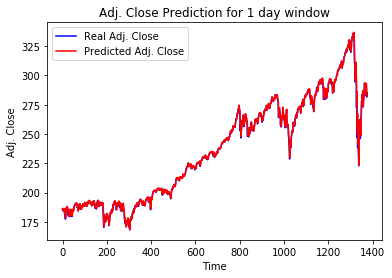

--- Polynomial Features Regression ---
--- Model Evaluation Metrics:
Mean squared error: 8.147026222038573
R-squared: 0.9955466182984353
Adjusted R-squared: 0.9955270859225512


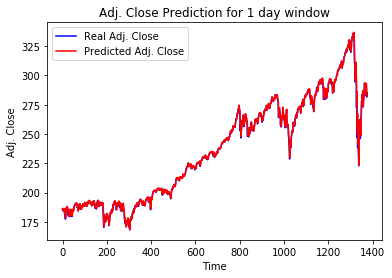

--- Support Vector Regression ---


/home/max/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--- Model Evaluation Metrics:
Mean squared error: 9.14665021096923
R-squared: 0.9950001971799287
Adjusted R-squared: 0.9949782682201915


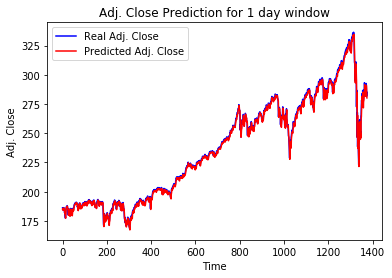

--- LASSO Regression ---
--- Model Evaluation Metrics:
Mean squared error: 8.227769119995903
R-squared: 0.9955024820781145
Adjusted R-squared: 0.9954827561223168


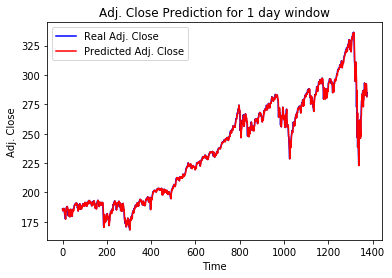

--- Ridge Regression ---
--- Model Evaluation Metrics:
Mean squared error: 8.130603988586445
R-squared: 0.9955555951289943
Adjusted R-squared: 0.9955361021251741


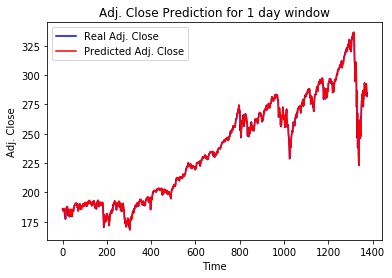

--- Elastic Net Regression ---
--- Model Evaluation Metrics:
Mean squared error: 8.385705932310442
R-squared: 0.9954161496065114
Adjusted R-squared: 0.9953960449995224


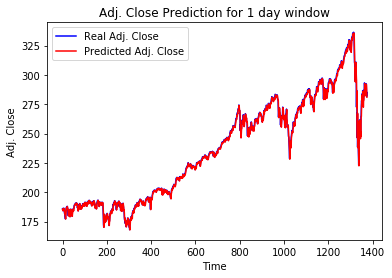

Lowest mean squared error: 8.130603988586445 / Regressor: Ridge Regression
Highest adjusted R-squared: 0.9955361021251741 / Regressor: Ridge Regression

########################## Window: 5 working days ##########################
--- Multiple Linear Regression ---
--- Model Evaluation Metrics:
Mean squared error: 35.75531528005125
R-squared: 0.9804498830515482
Adjusted R-squared: 0.9803640741988118


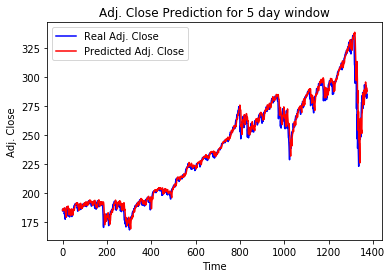

--- Polynomial Features Regression ---
--- Model Evaluation Metrics:
Mean squared error: 35.75531528005125
R-squared: 0.9804498830515482
Adjusted R-squared: 0.9803640741988118


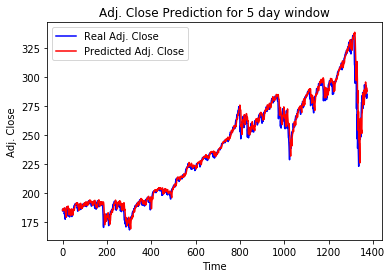

--- Support Vector Regression ---


/home/max/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--- Model Evaluation Metrics:
Mean squared error: 35.255061167973096
R-squared: 0.9807234095557469
Adjusted R-squared: 0.9806388012582593


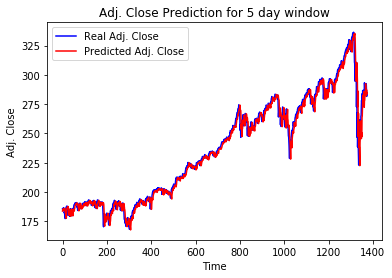

--- LASSO Regression ---
--- Model Evaluation Metrics:
Mean squared error: 34.15143381646516
R-squared: 0.9813268455377959
Adjusted R-squared: 0.9812448858254527


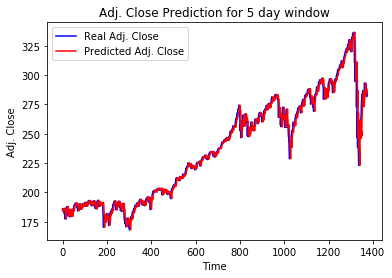

--- Ridge Regression ---
--- Model Evaluation Metrics:
Mean squared error: 34.08368090095469
R-squared: 0.9813638911465803
Adjusted R-squared: 0.9812820940338367


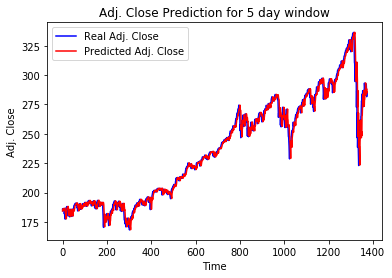

--- Elastic Net Regression ---
--- Model Evaluation Metrics:
Mean squared error: 34.15143381646516
R-squared: 0.9813268455377959
Adjusted R-squared: 0.9812448858254527


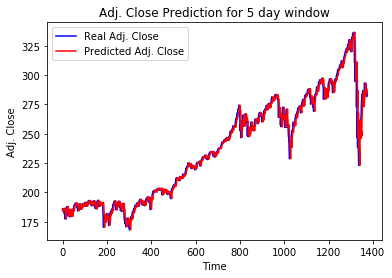

Lowest mean squared error: 34.08368090095469 / Regressor: Ridge Regression
Highest adjusted R-squared: 0.9812820940338367 / Regressor: Ridge Regression

########################## Window: 10 working days ##########################
--- Multiple Linear Regression ---
--- Model Evaluation Metrics:
Mean squared error: 75.41374830678276
R-squared: 0.958753706867218
Adjusted R-squared: 0.9585725372048485


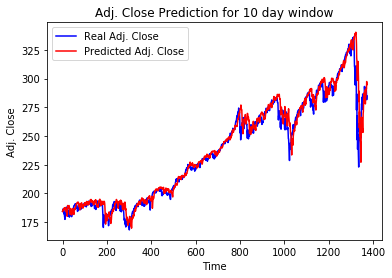

--- Polynomial Features Regression ---
--- Model Evaluation Metrics:
Mean squared error: 75.41374830678276
R-squared: 0.958753706867218
Adjusted R-squared: 0.9585725372048485


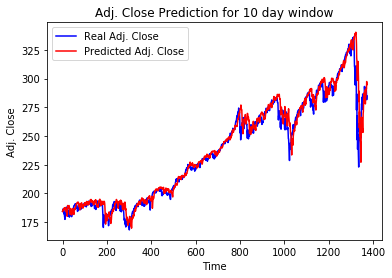

--- Support Vector Regression ---


/home/max/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--- Model Evaluation Metrics:
Mean squared error: 71.59803403351887
R-squared: 0.9608406482135856
Adjusted R-squared: 0.9606686452042749


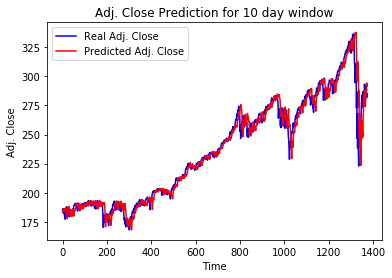

--- LASSO Regression ---
--- Model Evaluation Metrics:
Mean squared error: 70.61247208318055
R-squared: 0.961379684901416
Adjusted R-squared: 0.9612100495495921


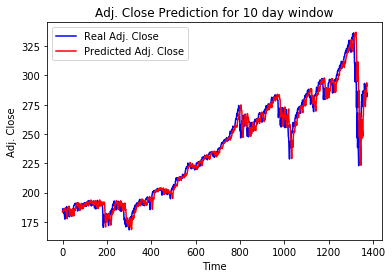

--- Ridge Regression ---
--- Model Evaluation Metrics:
Mean squared error: 70.57352846517111
R-squared: 0.9614009844644286
Adjusted R-squared: 0.9612314426685183


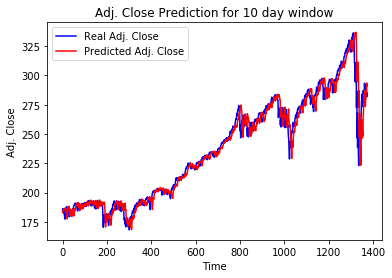

--- Elastic Net Regression ---
--- Model Evaluation Metrics:
Mean squared error: 70.61247208318055
R-squared: 0.961379684901416
Adjusted R-squared: 0.9612100495495921


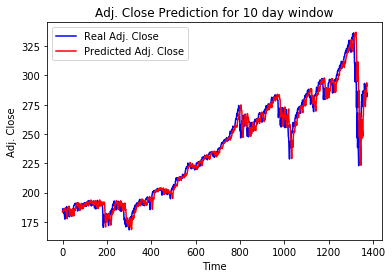

Lowest mean squared error: 70.57352846517111 / Regressor: Ridge Regression
Highest adjusted R-squared: 0.9612314426685183 / Regressor: Ridge Regression

########################## Window: 20 working days ##########################
--- Multiple Linear Regression ---
--- Model Evaluation Metrics:
Mean squared error: 166.6136525902577
R-squared: 0.9088149684430972
Adjusted R-squared: 0.9084138612661606


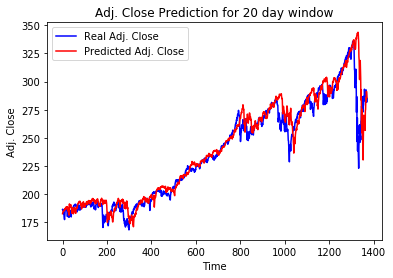

--- Polynomial Features Regression ---
--- Model Evaluation Metrics:
Mean squared error: 166.6136525902577
R-squared: 0.9088149684430972
Adjusted R-squared: 0.9084138612661606


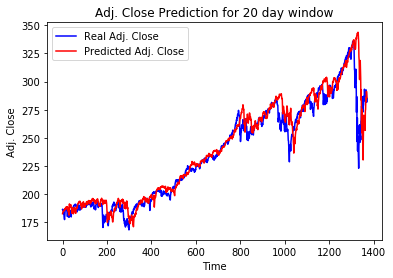

--- Support Vector Regression ---


/home/max/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--- Model Evaluation Metrics:
Mean squared error: 160.2989116741757
R-squared: 0.912270926827988
Adjusted R-squared: 0.9118850218140349


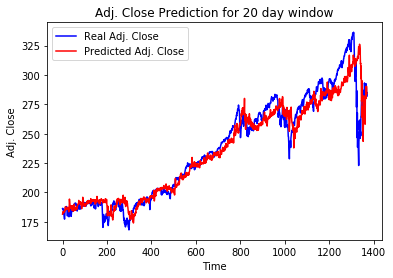

--- LASSO Regression ---
--- Model Evaluation Metrics:
Mean squared error: 154.8318921535843
R-squared: 0.9152629406261208
Adjusted R-squared: 0.9148901969631859


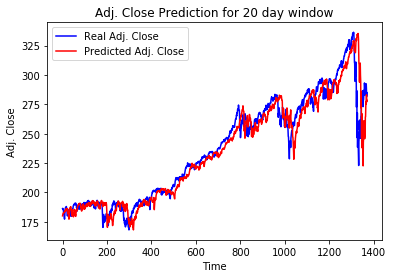

--- Ridge Regression ---
--- Model Evaluation Metrics:
Mean squared error: 153.91673384077316
R-squared: 0.9157637923770782
Adjusted R-squared: 0.9153932518743381


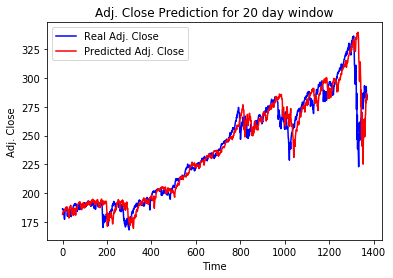

--- Elastic Net Regression ---
--- Model Evaluation Metrics:
Mean squared error: 164.04446061672675
R-squared: 0.9102210468018634
Adjusted R-squared: 0.9098261247203467


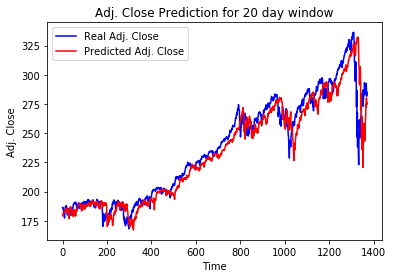

Lowest mean squared error: 153.91673384077316 / Regressor: Ridge Regression
Highest adjusted R-squared: 0.9153932518743381 / Regressor: Ridge Regression



In [158]:
for window in windows:
    X, y = import_engineer_data(window = window)
    lowest_mse = 1000
    highest_adj_r2 = 0.001
    print('########################## Window: {} working days ##########################'.format(window))
    for regressor in regressors_scalers:
        print('--- {} ---'.format(regressor))
        y_pred, y_test, err, mse, r2, adj_r2 = split_scale_train_predict(X, y, regressor = regressors_scalers[regressor][0], scaler = regressors_scalers[regressor][1])
        if mse < lowest_mse:
            lowest_mse = mse
            best_mse_model = regressor
        if adj_r2 > highest_adj_r2:
            highest_adj_r2 = adj_r2
            best_adj_r2_model = regressor
        plot_results(y_pred, y_test, err, window)
    print('Lowest mean squared error: {} / Regressor: {}'.format(lowest_mse, best_mse_model))
    print('Highest adjusted R-squared: {} / Regressor: {}'.format(highest_adj_r2, best_adj_r2_model))
    print('')

### Conclusion:
Ridge regression performs best on all four time windows when looking at both lowest mean squared error and hightest adjusted R-squared. This might be the case because of multicollinearity between the features, where Ridge regression has an advantage over the other regression models, especially compared to the ordinary least squares method in the multiple linear regression.  
--> Deciding for Ridge Regression as final model

### <a class="anchor" id="Conclusion">Part 8: Final Model Evaluation and Conclusion</a>
The Data Scientist Nanodegree recommends a prediction accuracy of +/-5%. We will therefore look at histograms of prediction errors and their confidence intervals. We will furthermore build a random model, randomly predicting prices within the standard deviation so as to see if our models are better than random choices. Our model will be a GridSearchCV optimized Ridge regression - the best performing model of the previous chapter.

In [ ]:
# Run Ridge regression model and obtain errors for histograms

In [159]:
# Run Ridge regression mode and obtain y_pred and y_test
window_ridge_data = []
for window in windows:
    X, y = import_engineer_data(window = window)
    print('########################## Window: {} working days ##########################'.format(window))
    y_pred, y_test, err, mse, r2, adj_r2 = split_scale_train_predict(X, y, regressor = regressors_scalers['Ridge Regression'][0], scaler = regressors_scalers['Ridge Regression'][1])
    err = y_test - y_pred
    window_ridge_data.append([y_pred, y_test, err, window])

########################## Window: 1 working days ##########################
--- Model Evaluation Metrics:
Mean squared error: 8.130603988586445
R-squared: 0.9955555951289943
Adjusted R-squared: 0.9955361021251741
########################## Window: 5 working days ##########################
--- Model Evaluation Metrics:
Mean squared error: 34.08368090095469
R-squared: 0.9813638911465803
Adjusted R-squared: 0.9812820940338367
########################## Window: 10 working days ##########################
--- Model Evaluation Metrics:
Mean squared error: 70.57352846517111
R-squared: 0.9614009844644286
Adjusted R-squared: 0.9612314426685183
########################## Window: 20 working days ##########################
--- Model Evaluation Metrics:
Mean squared error: 153.91673384077316
R-squared: 0.9157637923770782
Adjusted R-squared: 0.9153932518743381


In [154]:
# Calculate erros from window_ridge_data (window, y_test, y_pred, err)
window_ridge_data
# plot_results(y_pred, y_test, error, window)

[[1,
  array([[186.035278],
         [185.641068],
         [184.350876],
         ...,
         [286.670013],
         [281.600006],
         [284.970001]]),
  array([[185.59539872],
         [186.04383314],
         [185.6802573 ],
         ...,
         [292.61314516],
         [287.05896459],
         [281.85562623]]),
  array([[ 0.43987928],
         [-0.40276514],
         [-1.3293813 ],
         ...,
         [-5.94313216],
         [-5.45895859],
         [ 3.11437477]])],
 [5,
  array([[185.641068],
         [184.350876],
         [185.542526],
         ...,
         [286.670013],
         [281.600006],
         [284.970001]]),
  array([[184.29312532],
         [185.34539149],
         [185.82191367],
         ...,
         [286.42267615],
         [284.57742652],
         [287.87813091]]),
  array([[ 1.34794268],
         [-0.99451549],
         [-0.27938767],
         ...,
         [ 0.24733685],
         [-2.97742052],
         [-2.90812991]])],
 [10,
  array([[184.350876],

In [ ]:
# Histograms of prediction errors and confidence intervals

In [ ]:
# Comparison against Random Model

### For further information

LASSO, Ridge and 

######## LASSO Regression (better than mlr for heavy correlation bewtween features)
from sklearn.linear_model import LassoCV
model = LassoCV()

y_train = y_train.ravel()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred = y_pred.reshape((len(y_pred), 1))


#######  Ridge (like LASSO but L2 error is calculated --> higher punishment for bigger errors)
from sklearn.linear_model import RidgeCV
model = Ridge()
model.fit(X_train, y_train)


####### Elastic Net (mixes L1 and L2 error)
from sklearn.linear_model import ElasticNetCV
model = ElasticNetCV()
model.fit(X_train, y_train)